In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ldf = pd.read_csv("Indian Liver Patient Dataset (ILPD).csv")
ldf.head()

,age,gender,tot_bilirubin,direct_bilirubin,tot_proteins,albumin,ag_ratio,sgpt,sgot,alkphos,is_patient
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [3]:
print("Shape" + str(ldf.shape))
print("Any na values: ")
for col in ldf.columns:
    print(str(col) + "  :  " + str(sum(ldf[col].isna())))

Shape(583, 11)
Any na values: 
age  :  0
gender  :  0
tot_bilirubin  :  0
direct_bilirubin  :  0
tot_proteins  :  0
albumin  :  0
ag_ratio  :  0
sgpt  :  0
sgot  :  0
alkphos  :  4
is_patient  :  0


In [4]:
ldf = ldf.dropna(axis=0).reset_index(drop=True)
print("dropped na shape" + str(ldf.shape))


dropped na shape(579, 11)


In [5]:
ldf.dtypes

age                   int64
gender               object
tot_bilirubin       float64
direct_bilirubin    float64
tot_proteins          int64
albumin               int64
ag_ratio              int64
sgpt                float64
sgot                float64
alkphos             float64
is_patient            int64
dtype: object

In [6]:
ldf['isFemale'] = [1 if gender == 'Female' else 0 for gender in ldf['gender']]
ldf = ldf.drop('gender',axis=1)
ldf['is_patient'] = [1 if isp == 1 else 0 for isp in ldf['is_patient']]
sum(ldf['isFemale'])

140

In [7]:
X = ldf.drop('is_patient',axis=1)
y = ldf['is_patient']

age
tot_bilirubin
direct_bilirubin
tot_proteins
albumin
ag_ratio
sgpt
sgot
alkphos
isFemale


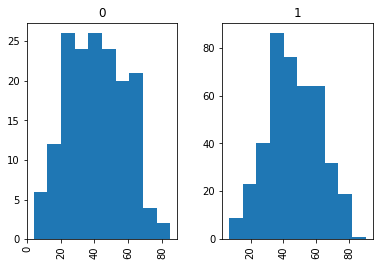

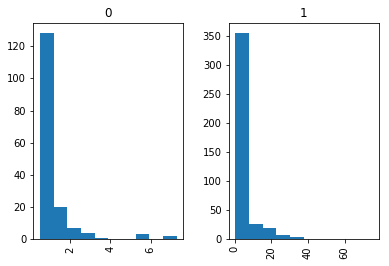

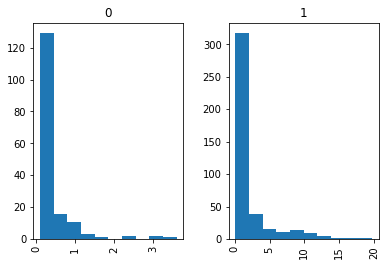

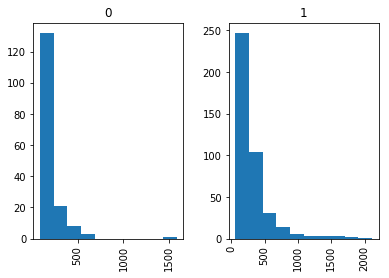

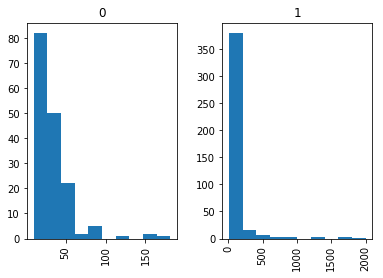

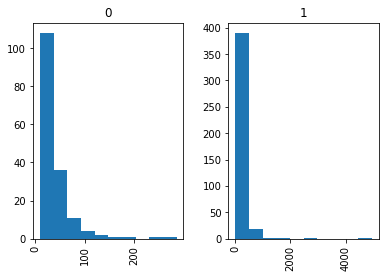

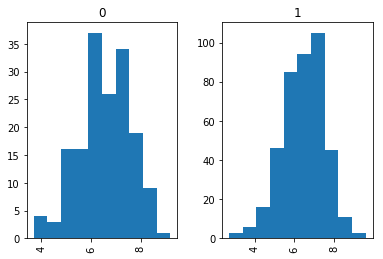

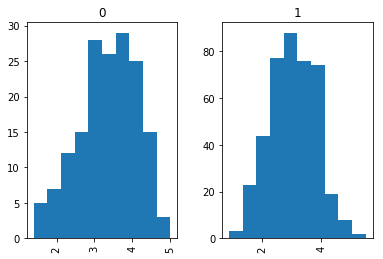

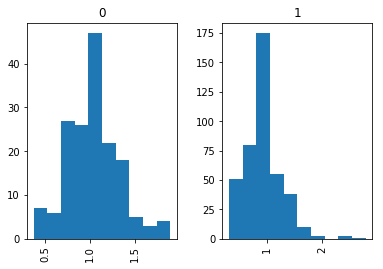

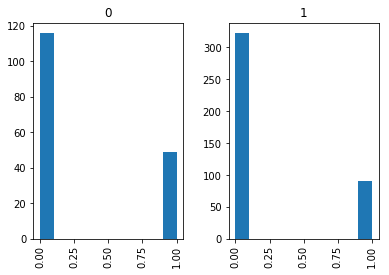

In [8]:
for col in X.columns:
    print(col)
    ldf.hist(col,by='is_patient',)

#Train-Test Split

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, stratify=y, random_state=0)
X_train, X_test, y_train, y_test = X_train.astype(np.float64), X_test.astype(np.float64), y_train.astype(np.float64), y_test.astype(np.float64)

#Principle Component Analysis


In [10]:
# standardize the features
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 
X_train_std = sc.fit_transform(X_train) 
X_test_std = sc.transform(X_test) 

In [11]:
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat) 
eigen_vals

array([2.71270769, 2.12306675, 1.33320815, 1.07107833, 0.92105007,
       0.82106915, 0.62916487, 0.05310767, 0.199729  , 0.16206505])

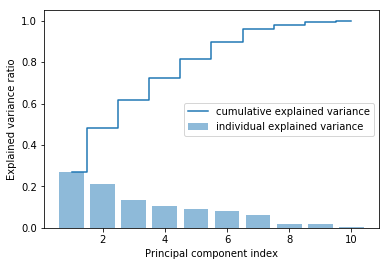

In [12]:
tot = sum(eigen_vals) 
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)] 
cum_var_exp = np.cumsum(var_exp) 
plt.bar(range(1,len(var_exp)+1), var_exp, alpha=0.5, align='center', label='individual explained variance') 
plt.step(range(1,len(var_exp)+1), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio') 
plt.xlabel('Principal component index') 
plt.legend(loc='best') 
plt.show()

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=7) #looks like a good spot based on above graph
X_train_pca = pca.fit_transform(X_train_std) 
X_test_pca = pca.transform(X_test_std) 

#Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_pca,y_train)
y_pred = lr.predict(X_test_pca)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.6954314720812182

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred,labels = [1,0])

array([[119,  22],
       [ 38,  18]], dtype=int64)

#KNN + 10-fold cross-validation

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
all_scores = []
for n_neighbors in range(3,11,2):
    knn_clf = KNeighborsClassifier(n_neighbors = n_neighbors)
    all_scores.append((n_neighbors, cross_val_score(knn_clf, X_train_pca, y_train, cv=10).mean()))
sorted(all_scores, key = lambda x:x[1], reverse = True)

[(7, 0.7145420724368093),
 (9, 0.7120417988839042),
 (5, 0.6830944304628515),
 (3, 0.6675821570558412)]

it appears the best number of neighbors is 7
Accuracy matches the accuracy reported in the 2012 paper